In [1]:
import os
import time
import sys
import subprocess
import numpy as np
import vectorbt as vbt
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit


In [2]:
price = vbt.YFData.download('BTC-USD', start='2018-01-01', end = '2024-01-01')
price

In [3]:
st = time.time()
close = price.get('Close')
fast_ma = vbt.MA.run(close, 5, short_name='fast_ma')
slow_ma = vbt.MA.run(close, 10, short_name='slow_ma')
entries = fast_ma.ma_crossed_above(slow_ma)
exits = fast_ma.ma_crossed_below(slow_ma)
pf = vbt.Portfolio.from_signals(close, entries, exits, fees=0.000)
et = time.time()
print(f'Elapsed time: {1000*(et-st):.2f} ms')
print(f'Total return: {pf.total_return()}')

Elapsed time: 5503.94 ms
Total return: 2.09876466123077


In [4]:
data = vbt.YFData.download(
    ['BTC-USD'],
    start='2018-01-01',
    end = '2024-01-01'
)

high = data.get('High')
low = data.get('Low')
close = data.get('Close')

In [17]:
def get_med_price(high, low):
    return (high + low) / 2
  
def get_atr(high, low, close, period):
    tr0 = abs(high - low)
    tr1 = abs(high - close.shift())
    tr2 = abs(low - close.shift())
    tr = pd.concat((tr0, tr1, tr2), axis=1).max(axis=1)
    atr = tr.ewm(alpha=1 / period, adjust=False, min_periods=period).mean()
    return atr
  
def get_basic_bands(med_price, atr, multiplier):
    matr = multiplier * atr
    upper = med_price + matr
    lower = med_price - matr
    return upper, lower
  
def get_basic_bands(med_price, atr, multiplier):
    matr = multiplier * atr
    upper = med_price + matr
    lower = med_price - matr
    return upper, lower
  
def get_final_bands(close, upper, lower):
    trend = pd.Series(np.full(close.shape, np.nan), index=close.index)
    dir_ = pd.Series(np.full(close.shape, 1), index=close.index)
    long = pd.Series(np.full(close.shape, np.nan), index=close.index)
    short = pd.Series(np.full(close.shape, np.nan), index=close.index)

    for i in range(1, close.shape[0]):
        if close.iloc[i] > upper.iloc[i - 1]:
            dir_.iloc[i] = 1
        elif close.iloc[i] < lower.iloc[i - 1]:
            dir_.iloc[i] = -1
        else:
            dir_.iloc[i] = dir_.iloc[i - 1]
            if dir_.iloc[i] > 0 and lower.iloc[i] < lower.iloc[i - 1]:
                lower.iloc[i] = lower.iloc[i - 1]
            if dir_.iloc[i] < 0 and upper.iloc[i] > upper.iloc[i - 1]:
                upper.iloc[i] = upper.iloc[i - 1]

        if dir_.iloc[i] > 0:
            trend.iloc[i] = long.iloc[i] = lower.iloc[i]
        else:
            trend.iloc[i] = short.iloc[i] = upper.iloc[i]
            
    return trend, dir_, long, short
  

def faster_supertrend(high, low, close, period=14, multiplier=3):
    med_price = get_med_price(high, low)
    atr = get_atr(high, low, close, period)
    upper, lower = get_basic_bands(med_price, atr, multiplier)
    trend, dir_, long, short = get_final_bands(close, upper, lower)
    return trend, dir_, long, short, upper, lower, atr

st = time.time()
supert, superd, superl, supers, upper, lower, atr = faster_supertrend(
    high, 
    low, 
    close
)

entries = (~superl.isnull()).vbt.signals.fshift()
exits = (~supers.isnull()).vbt.signals.fshift()
pf = vbt.Portfolio.from_signals(
    close=close, 
    entries=entries, 
    exits=exits, 
    fees=0.000
)
et = time.time()
print(f'Elapsed time: {1000*(et-st):.2f} ms')

Elapsed time: 251.64 ms


In [18]:
supert.head(20)

Date
2018-01-01 00:00:00+00:00             NaN
2018-01-02 00:00:00+00:00             NaN
2018-01-03 00:00:00+00:00             NaN
2018-01-04 00:00:00+00:00             NaN
2018-01-05 00:00:00+00:00             NaN
2018-01-06 00:00:00+00:00             NaN
2018-01-07 00:00:00+00:00             NaN
2018-01-08 00:00:00+00:00             NaN
2018-01-09 00:00:00+00:00             NaN
2018-01-10 00:00:00+00:00             NaN
2018-01-11 00:00:00+00:00             NaN
2018-01-12 00:00:00+00:00             NaN
2018-01-13 00:00:00+00:00             NaN
2018-01-14 00:00:00+00:00    10205.172260
2018-01-15 00:00:00+00:00    10449.824472
2018-01-16 00:00:00+00:00    10449.824472
2018-01-17 00:00:00+00:00    10449.824472
2018-01-18 00:00:00+00:00    10449.824472
2018-01-19 00:00:00+00:00    10449.824472
2018-01-20 00:00:00+00:00    10449.824472
Freq: D, dtype: float64

In [22]:
df = pd.DataFrame({
    'Close': close,
    'Supertrend': supert,
    'Superdir': superd,
    'Superl': superl,
    'Supers': supers,
    "Upper": upper,
    "Lower": lower,
})
df.index = pd.to_datetime(df.index)
df.head(20)

,Close,Supertrend,Superdir,Superl,Supers,Upper,Lower
Date,,,,,,,
2018-01-01 00:00:00+00:00,13657.200195,NaN,1,NaN,NaN,NaN,NaN
2018-01-02 00:00:00+00:00,14982.099609,NaN,1,NaN,NaN,NaN,NaN
2018-01-03 00:00:00+00:00,15201.000000,NaN,1,NaN,NaN,NaN,NaN
2018-01-04 00:00:00+00:00,15599.200195,NaN,1,NaN,NaN,NaN,NaN
2018-01-05 00:00:00+00:00,17429.500000,NaN,1,NaN,NaN,NaN,NaN
2018-01-06 00:00:00+00:00,17527.000000,NaN,1,NaN,NaN,NaN,NaN
2018-01-07 00:00:00+00:00,16477.599609,NaN,1,NaN,NaN,NaN,NaN
2018-01-08 00:00:00+00:00,15170.099609,NaN,1,NaN,NaN,NaN,NaN
2018-01-09 00:00:00+00:00,14595.400391,NaN,1,NaN,NaN,NaN,NaN


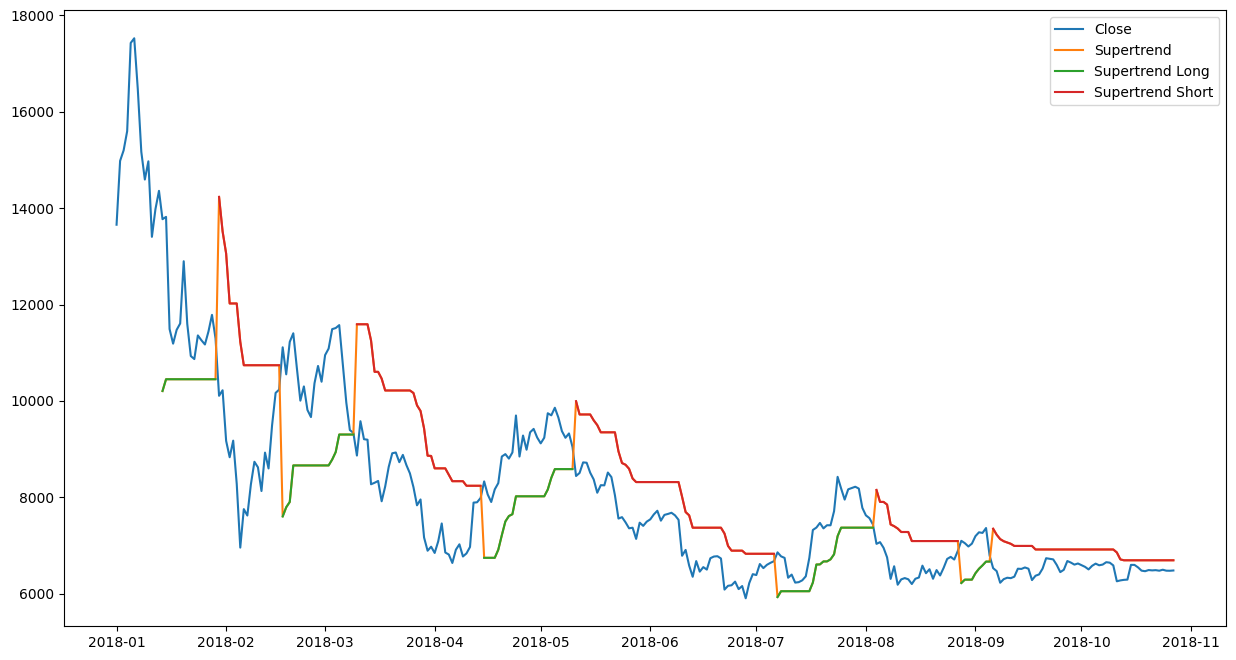

In [26]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
n = 300
ax.plot(close.iloc[0:n], label='Close')
ax.plot(supert.iloc[0:n], label='Supertrend')
ax.plot(superl.iloc[0:n], label='Supertrend Long')
ax.plot(supers.iloc[0:n], label='Supertrend Short')
ax.legend()

In [27]:
superl.tail(2), supers.tail(2)

(Date
 2023-12-31 00:00:00+00:00    40304.667242
 2024-01-01 00:00:00+00:00    40304.667242
 Freq: D, dtype: float64,
 Date
 2023-12-31 00:00:00+00:00   NaN
 2024-01-01 00:00:00+00:00   NaN
 Freq: D, dtype: float64)

In [11]:
supers.head(20)

Date
2018-01-01 00:00:00+00:00   NaN
2018-01-02 00:00:00+00:00   NaN
2018-01-03 00:00:00+00:00   NaN
2018-01-04 00:00:00+00:00   NaN
2018-01-05 00:00:00+00:00   NaN
2018-01-06 00:00:00+00:00   NaN
2018-01-07 00:00:00+00:00   NaN
2018-01-08 00:00:00+00:00   NaN
2018-01-09 00:00:00+00:00   NaN
2018-01-10 00:00:00+00:00   NaN
2018-01-11 00:00:00+00:00   NaN
2018-01-12 00:00:00+00:00   NaN
2018-01-13 00:00:00+00:00   NaN
2018-01-14 00:00:00+00:00   NaN
2018-01-15 00:00:00+00:00   NaN
2018-01-16 00:00:00+00:00   NaN
2018-01-17 00:00:00+00:00   NaN
2018-01-18 00:00:00+00:00   NaN
2018-01-19 00:00:00+00:00   NaN
2018-01-20 00:00:00+00:00   NaN
Freq: D, dtype: float64